In [1]:
from shapely.geometry import Point,mapping, LineString, Polygon, MultiPoint
import numpy as np
import rasterio
from rasterio import plot, mask
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
OS_National_Grids = gpd.read_file(os.path.join('OS-British-National-Grids-main','OS-British-National-Grids-main','os_bng_grids.gpkg'),layer='1km_grid')

In [3]:
study_area_shapely = OS_National_Grids[OS_National_Grids['tile_name'] == "SX7677"].geometry.cascaded_union

In [4]:
Haytor_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_SX77-Haytor_2033809', 'raster-25k_4596071', 'sx', 'sx77.tif'))
elevation = rasterio.open(os.path.join('OS Elevation','Download_Haytor_Elevation_2035988','terrain-5-dtm_4600215','sx','SX77NE.asc'))

study_area = mapping(study_area_shapely)
elevation_mask, transform_index = mask.mask(elevation,[study_area], filled=False, crop=False)

network_links = gpd.read_file(os.path.join('Study_area','SX7677','network_links.geojson'))
network_nodes = gpd.read_file(os.path.join('Study_area','SX7677','network_nodes.geojson'))


##  3. OS Detailed Path Network

In [5]:
path_network = gpd.read_file(os.path.join('Detailed-Path-Network', 'DARTMOOR NATIONAL PARK.gml'),layer='RouteLink')

In [6]:
OSDPN= path_network.intersection(study_area_shapely)
OSDPN= OSDPN[~OSDPN.is_empty]
OSDPN_gpd = gpd.GeoDataFrame(geometry=OSDPN)

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


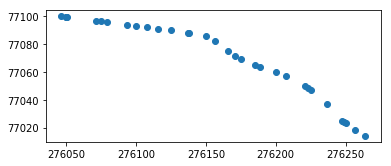

In [7]:
row1=OSDPN_gpd.iloc[2]
first_path_gpd = gpd.GeoSeries(row1)
intersects = {}
geom_points = []
height = []
fid = []
count = 1
previous_point = 0
for index2, row2 in network_links.iterrows():
    intersecting_point = row1.geometry.intersection(row2.geometry)
    if not intersecting_point.is_empty:
        if intersecting_point != previous_point:
            network_node = [(Point(row2['geometry'].bounds[0],row2['geometry'].bounds[1])),(Point(row2['geometry'].bounds[2],row2['geometry'].bounds[3]))]
            if intersecting_point.geom_type != 'MultiPoint':
                intersects[count]= intersecting_point
                geom_points.append(intersecting_point)
                height.append(intersecting_point.z)
                intersecting_point_fid = 'dpn_' + str(count)
                fid.append(intersecting_point_fid)

                count = count + 1
            else:
                for pt in intersecting_point:
                    intersects[count]=(Point(pt.x, pt.y,pt.z))
                    geom_points.append(Point(pt.x, pt.y,pt.z))
                    height.append(pt.z)
                    intersecting_point_fid = 'al+dpn_' + str(count)
                    fid.append(intersecting_point_fid)

                    count = count + 1

            previous_point = intersecting_point

DPN_paths_nodes = gpd.GeoDataFrame({'fid': fid,'height':height,'DPN': 1, 'geometry': geom_points},crs = 27700)
points = MultiPoint(geom_points)
DPN_paths_nodes.plot()

In [48]:
import shapely as shapely
from shapely.ops import split,snap
points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
line_2d = shapely.wkb.loads(shapely.wkb.dumps(row1.geometry, output_dimension=2))

In [56]:
for point in points_2d:
    print(line_2d.within(point))
    print(line_2d.distance(point))
    print(line_2d.distance(point) < 1e-8)

False
3.697393763455692e-12
True
False
3.717939345529438e-12
True
False
2.650109750907081e-12
True
False
3.153746848320107e-12
True
False
6.700563122103734e-12
True
False
1.885327491872486e-12
True
False
3.157531560807376e-12
True
False
5.506215995764095e-12
True
False
6.421035071258287e-12
True
False
4.420544185130326e-12
True
False
3.2840490925246575e-12
True
False
3.4711220240382456e-12
True
False
2.430866763251706e-12
True
False
6.51835624950235e-12
True
False
3.5954408597403846e-13
True
False
2.1722622877621997e-13
True
False
1.0970391961881167e-11
True
False
1.1115964343303924e-11
True
False
1.343306967953563e-12
True
False
1.9774373219912115e-12
True
False
7.091192556251949e-13
True
False
1.1689181216193475e-11
True
False
3.067808272767468e-12
True
False
8.405532135129306e-12
True
False
7.254903902594528e-12
True
False
6.220075745847182e-13
True
False
2.443590601638062e-12
True
False
1.848340443390499e-11
True
False
1.6470093867610594e-11
True
False
2.8112323568726686e-12
True
F

In [69]:
snapped_points_2d = snap(points_2d,line_2d, 10)
snapped_points_2d_gpd = gpd.GeoSeries(snapped_points_2d)
snapped_points_2d.wkt

'MULTIPOINT (276049.5697851643 77099.56978516433, 276039.55 77100.886, 276050 77099.5132714627, 276071.6670530814 77096.66705308143, 276050.5603350342 77099.43966496587, 276075 77096.22923189976, 276093.7643209985 77093.76432099854, 276079.3410100501 77095.65898994985, 276100 77092.94519233683, 276115.8615889156 77090.86158891565, 276108.1216850661 77091.87831493384, 276125 77089.66115277392, 276155.307 77082.785, 276155.307 77082.785, 276177.297 77067.649, 276155.307 77082.785, 276177.297 77067.649, 276155.307 77082.785, 276177.297 77067.649, 276188.6926143061 77063.6926143061, 276177.297 77067.649, 276220.138 77050.71400000001, 276207.474 77057.17200000001, 276220.138 77050.71400000001, 276207.474 77057.17200000001, 276253.465 77020.14200000001, 276220.138 77050.71400000001, 276253.465 77020.14200000001, 276234.336 77039.727, 276253.465 77020.14200000001, 276271.101 77011.645, 276253.465 77020.14200000001)'

In [52]:
# test point extracted from linestring works
point = Point(276177.297,77067.649)

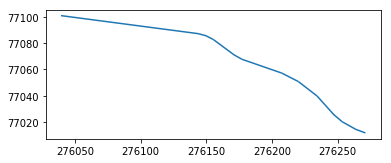

In [68]:
splitted = split(line_2d,snapped_points_2d)
splitted.wkt
lines = []
for lin in splitted:
    lines.append(lin)
splitted_lines = gpd.GeoSeries(lines)
splitted_lines.plot()

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


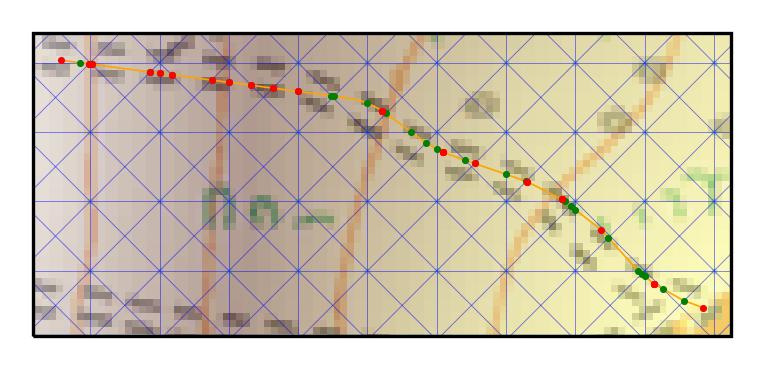

In [71]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                   cmap='terrain')
# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.3)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.3)

#
DPN_paths_nodes.plot(ax=ax,zorder=6,color='green',markersize=0.5)
snapped_points_2d_gpd.plot(ax=ax,zorder=6,color='red',markersize=0.5)
#first_path_gpd.plot(ax=ax,zorder = 4,color='red', linewidth=0.4)
splitted_lines.plot(ax=ax,zorder = 5,color='orange', linewidth=0.4)
# DPN_paths_nodes.plot(ax=ax,zorder = 5,markersize=0.2)
# DPN_paths_links.plot(ax=ax,zorder = 4, linewidth=0.2)

display_extent = ((first_path_gpd.total_bounds[0] - 10, first_path_gpd.total_bounds[2] + 10,
                   first_path_gpd.total_bounds[1] - 10, first_path_gpd.total_bounds[3] + 10))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()